In [26]:
# =====================================================
# CELL 1 — Imports
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os
import seaborn as sns

plt.style.use("default")   # avoid seaborn styles error


In [22]:
# =====================================================
# CELL 2 — Load Engineered PhysioNet Features
# =====================================================

# You already saved these earlier
FEATURES_FILE = "../data/bidmc/models/physionet_features.pkl"
SCALER_FILE = "../data/bidmc/models/physionet_scaler.joblib"

# Load features
features = joblib.load(FEATURES_FILE)

print("Loaded Features:", features)


Loaded Features: ['BREATH_ANNOTATIONS', 'HR', 'SPO2', 'HR_MEAN', 'HR_STD', 'HR_DIFF', 'SPO2_DIFF', 'BREATH_COUNT', 'HR_VAR', 'SPO2_TREND', 'BREATH_RATE_AVG']


In [23]:
# =====================================================
# CELL 3 — Load Preprocessed PhysioNet Dataset
# =====================================================

# IMPORTANT:
# We reconstruct the features using the combined_data CSV you created earlier.
# If you saved your combined processed dataset, load it here:

DATA_FILE = "../data/processed_physionet_data.csv"  # <-- update if filename differs

if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"Processed file {DATA_FILE} not found.")

df = pd.read_csv(DATA_FILE)
print("Loaded dataset:", df.shape)
df.head()


Loaded dataset: (3205546, 13)


,BREATH_ANNOTATIONS,HR,SPO2,HR_MEAN,HR_STD,HR_DIFF,SPO2_DIFF,BREATH_COUNT,HR_VAR,SPO2_TREND,BREATH_RATE_AVG,HR_ANOMALY,SPO2_ANOMALY
0,0.0,87,97,87.000000,NaN,NaN,NaN,0.353862,NaN,0.0,0.353862,0,0
1,0.0,76,95,81.500000,7.778175,-11.0,-2.0,0.710654,60.500000,0.0,0.355327,0,0
2,0.0,67,98,76.666667,10.016653,-9.0,3.0,1.069399,100.333333,0.0,0.356466,0,0
3,0.0,94,99,81.000000,11.916375,27.0,1.0,1.431074,142.000000,0.0,0.357768,0,0
4,0.0,63,94,77.400000,13.088163,-31.0,-5.0,1.794717,171.300000,0.0,0.358943,0,0


In [24]:
# =====================================================
# CELL 4 — Feature Engineering for Disease Prediction
# =====================================================

import numpy as np

# Make a copy to avoid modifying the original dataframe
df_disease = df.copy()

# -------------------------------
# 1. Ensure all required numeric columns exist
# -------------------------------
required_features = [
    'BREATH_ANNOTATIONS', 'HR', 'SPO2', 'HR_MEAN', 'HR_STD', 'HR_DIFF',
    'SPO2_DIFF', 'BREATH_COUNT', 'HR_VAR', 'SPO2_TREND', 'BREATH_RATE_AVG'
]

for feat in required_features:
    if feat not in df_disease.columns:
        df_disease[feat] = 0  # fill missing features with zeros

# -------------------------------
# 2. Create or update derived features if necessary
# -------------------------------
if 'HR_MEAN' in df_disease.columns:
    df_disease['HR_VAR'] = df_disease['HR_MEAN'].rolling(window=30, min_periods=1).var()
if 'SPO2_DIFF' in df_disease.columns:
    df_disease['SPO2_TREND'] = df_disease['SPO2_DIFF'].rolling(window=30, min_periods=1).mean()
if 'ACTIVITY_ENERGY' in df_disease.columns:
    df_disease['ACTIVITY_AVG'] = df_disease['ACTIVITY_ENERGY'].rolling(window=30, min_periods=1).mean()
if 'BREATH_COUNT' in df_disease.columns:
    df_disease['BREATH_RATE_AVG'] = df_disease['BREATH_COUNT'].rolling(window=30, min_periods=1).mean()

# -------------------------------
# 3. Handle missing values
# -------------------------------
df_disease.fillna(method='ffill', inplace=True)
df_disease.fillna(method='bfill', inplace=True)

# -------------------------------
# 4. Select features for disease modeling
# -------------------------------
# Only use features expected by the disease prediction model
X_disease = df_disease[required_features]

print("Prepared disease prediction features:", X_disease.shape)
display(X_disease.head())


Prepared disease prediction features: (3205546, 11)


,BREATH_ANNOTATIONS,HR,SPO2,HR_MEAN,HR_STD,HR_DIFF,SPO2_DIFF,BREATH_COUNT,HR_VAR,SPO2_TREND,BREATH_RATE_AVG
0,0.0,87,97,87.000000,7.778175,-11.0,-2.0,0.353862,15.125000,-2.000000,0.353862
1,0.0,76,95,81.500000,7.778175,-11.0,-2.0,0.710654,15.125000,-2.000000,0.532258
2,0.0,67,98,76.666667,10.016653,-9.0,3.0,1.069399,26.731481,0.500000,0.711305
3,0.0,94,99,81.000000,11.916375,27.0,1.0,1.431074,17.951389,0.666667,0.891247
4,0.0,63,94,77.400000,13.088163,-31.0,-5.0,1.794717,16.894222,-0.750000,1.071941


Training samples: 2564436, Testing samples: 641110
Disease Prediction Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    641110

    accuracy                           1.00    641110
   macro avg       1.00      1.00      1.00    641110
weighted avg       1.00      1.00      1.00    641110



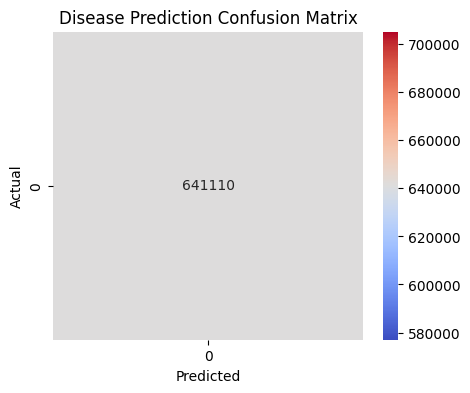

Saved Disease Prediction Model and full 11-feature list successfully!


In [28]:
# =====================================================
# CELL 5 — Train Disease Prediction Model (All 11 Features)
# =====================================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

# -------------------------------
# 0. Define full feature set (must match the features used in Cell 4)
# -------------------------------
disease_features_list = [
    'BREATH_ANNOTATIONS', 'HR', 'SPO2', 'HR_MEAN', 'HR_STD', 'HR_DIFF',
    'SPO2_DIFF', 'BREATH_COUNT', 'HR_VAR', 'SPO2_TREND', 'BREATH_RATE_AVG'
]

# Ensure all features exist in the dataframe
for feat in disease_features_list:
    if feat not in df_disease.columns:
        df_disease[feat] = 0

X_disease = df_disease[disease_features_list]

# -------------------------------
# 1. Ensure target columns exist
# -------------------------------
for col in ['HR_ANOMALY', 'SPO2_ANOMALY']:
    if col not in df_disease.columns:
        df_disease[col] = 0

# Define target variable (synthetic disease risk based on anomalies)
df_disease['DISEASE_RISK'] = df_disease[['HR_ANOMALY', 'SPO2_ANOMALY']].max(axis=1)
y_disease = df_disease['DISEASE_RISK']

# -------------------------------
# 2. Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_disease, y_disease, test_size=0.2, random_state=42, stratify=y_disease
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# -------------------------------
# 3. Train Random Forest Model
# -------------------------------
rf_disease_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_disease_model.fit(X_train, y_train)

# -------------------------------
# 4. Model Predictions
# -------------------------------
y_pred = rf_disease_model.predict(X_test)

# -------------------------------
# 5. Evaluation
# -------------------------------
print("Disease Prediction Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Disease Prediction Confusion Matrix")
plt.show()

# -------------------------------
# 6. Save Model and Features
# -------------------------------
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

# Save Random Forest model
joblib.dump(rf_disease_model, os.path.join(model_dir, "disease_rf_model.joblib"))

# Save features list used for the model
joblib.dump(disease_features_list, os.path.join(model_dir, "disease_features_list.joblib"))

print("Saved Disease Prediction Model and full 11-feature list successfully!")


In [29]:

model = joblib.load("../data/bidmc/models/disease_rf_model.joblib")
print("Model expects:", model.n_features_in_)
print("Feature names:", model.feature_names_in_)


Model expects: 11
Feature names: ['BREATH_ANNOTATIONS' 'HR' 'SPO2' 'HR_MEAN' 'HR_STD' 'HR_DIFF' 'SPO2_DIFF'
 'BREATH_COUNT' 'HR_VAR' 'SPO2_TREND' 'BREATH_RATE_AVG']
